# 심층 신경망을 이용한 이메일 분류

## [Sequential] 


In [1]:
# module import
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import string
from nltk import pos_tag
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### _1_. 데이터 준비

In [2]:
# 데이터 로드
train_data = fetch_20newsgroups(subset='train')
test_data = fetch_20newsgroups(subset='test')

In [3]:
# 데이터 준비
X_train, y_train = train_data.data, train_data.target
X_test, y_test = test_data.data, test_data.target
print(f"훈련 데이터: {len(X_train)}, 훈련 라벨: {len(y_train)}")
print(f"훈련 데이터: {len(X_test)}, 훈련 라벨: {len(y_test)}")

훈련 데이터: 11314, 훈련 라벨: 11314
훈련 데이터: 7532, 훈련 라벨: 7532


In [4]:
# 데이터 확인
print("뉴스 20개 카테고리")
print(f"{train_data.target_names}")
print("")
print("훈련용 샘플 이메일")
print(X_train[0])
print("")
print("훈련용 샘플 이메일 카테고리")
print(y_train[0])
print(test_data.target_names[y_train[0]])

뉴스 20개 카테고리
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']

훈련용 샘플 이메일
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or 

### _2_. 데이터 전처리

* `string.punctuation` 사용: `'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'`

---

* '\n'을 제거하기 위해 split() 후 다시 합침 --> 그냥 strip하면 안 되나??
* 표제어 추출?

In [5]:
def preprocessing(text):
    '''
    1) 구둣점 제거
    2) 개행문자 제거
    3) 토큰화
    4) 불용어 제거
    5) 길이 2이하 제거
    6) 어간 분석: optional
    7) 품사 태그
    8) 표제어 추출
    '''

    temp = '' # 남길 텍스트
    for ch in text:
        if ch in string.punctuation: # 구둣점 제거
            temp += ' '
        else:
            temp += ch
    temp = ' '.join(temp.split()) # 개행문자 제거

    tokens = []
    for sent in nltk.sent_tokenize(temp): # 문단 -> 문장
        for word in nltk.word_tokenize(sent): # 문장 -> 단어
            tokens.append(word.lower()) # 소문자
    
    # 불용어 제거, 길이 3이상인 단어만 남기기
    stopwords_list= stopwords.words('english')
    tokens = [token for token in tokens if token not in stopwords_list] # 토큰 중 불용어 제거
    tokens = [word for word in tokens if len(word) >= 3] # 길이 2이하 제거

    # # 어간 분석: optional
    # stemmer = PorterStemmer()
    # try:
    #     tokens = [stemmer.stem(word) for word in tokens]
    # except:
    #     tokens = tokens
    
    # 품사 태깅
    tagged_corpus = pos_tag(tokens)

    # lemmatize vs. pos
    n_tags = ['NN', 'NNP', 'NNPS', 'NNS']
    v_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

    # 표제어 추출
    lemmatizer = WordNetLemmatizer()
    def prat_lemmatize(token, tag):
        if tag in n_tags:
            return lemmatizer.lemmatize(token, 'n')
        elif tag in v_tags:
            return lemmatizer.lemmatize(token, 'v')
        else:
            return lemmatizer.lemmatize(token, 'n')  
    
    pre_processed_text = " ".join([prat_lemmatize(token, tag) for token, tag in tagged_corpus])

    return pre_processed_text

In [6]:
# 전처리 진행
X_train_preprocessed = []
for text in X_train:
    X_train_preprocessed.append(preprocessing(text))

X_test_preprocessed = []
for text in X_test:
    X_test_preprocessed.append(preprocessing(text))

# 전처리 후 데이터 확인
print("전처리된 훈련용 샘플 이메일")
print(X_train_preprocessed[0])

# 확인
print(f"전처리된 훈련 데이터: {len(X_train_preprocessed)}")
print(f"전처리된 테스트 데이터: {len(X_test_preprocessed)}")

전처리된 훈련용 샘플 이메일
lerxst wam umd edu thing subject car nntp post host rac3 wam umd edu organization university maryland college park line wonder anyone could enlighten car saw day door sport car look late 60 early 70 call bricklin door really small addition front bumper separate rest body know anyone tellme model name engine spec year production car make history whatever info funky look car please mail thanks bring neighborhood lerxst
전처리된 훈련 데이터: 11314
전처리된 테스트 데이터: 7532


### _3_. TFIDF 행렬 만들기

 sparse 행렬이므로 dense로 바꿔야 한다.

* `min_df` : 최소 2개 이상의 문서(문장)에 나타나야 함.
* `ngram` : unigram, bigram 사용.
* `max_features` : 단어 개수 100개로 지정.(문장 길이 관련)



In [7]:
# tf-idf 행렬
vectorizer = TfidfVectorizer(min_df=2, 
                             ngram_range=(1, 2),
                             stop_words='english',
                             max_features=10000)

In [8]:
# tf-idf 행렬 변환
tfidf_vectorizer = vectorizer.fit(X_train_preprocessed)
X_train_tfidf = tfidf_vectorizer.transform(X_train_preprocessed).todense()
print(f"훈련 데이터: {X_train_tfidf.shape}")
X_test_tfidf = tfidf_vectorizer.transform(X_test_preprocessed).todense()
print(f"테스트 데이터: {X_test_tfidf.shape}")

훈련 데이터: (11314, 10000)
테스트 데이터: (7532, 10000)


In [9]:
# vectorizer 확인
print(f"tfidf 행렬로 만드는 데 사용한 단어 개수: {len(tfidf_vectorizer.get_feature_names())}")
print("샘플 단어 10개 확인")
print(tfidf_vectorizer.get_feature_names()[:10]) # 예시로 확인

tfidf 행렬로 만드는 데 사용한 단어 개수: 10000
샘플 단어 10개 확인
['000', '000 000', '000 mile', '000 people', '000 year', '005', '02238', '02p', '030', '0358']


### _4_. 딥러닝 모델

In [10]:
# 파라미터 설정
np.random.seed(42) # 시드 고정
num_labels = len(np.unique(y_train)) # 라벨 20개
BATCH = int(input('배치 사이즈 설정: '))
EPOCHS = int(input('학습 에폭 수 설정: '))

배치 사이즈 설정: 100
학습 에폭 수 설정: 1000


In [11]:
# 라벨 범주형 변수로 변환
Y_train = to_categorical(y_train, num_classes=num_labels)
Y_test = to_categorical(y_test, num_classes=num_labels)
print(f"훈련 라벨: {Y_train.shape}")
print(f"테스트 라벨: {Y_test.shape}")

훈련 라벨: (11314, 20)
테스트 라벨: (7532, 20)


In [12]:
# 모델 설정
model = Sequential()

# 첫 번째 층
model.add(Dense(1000, input_shape=(X_train_tfidf.shape[1], ))) # 입력 데이터 shape: 10000개 단어, 11314개 데이터 수.
model.add(Activation('relu')) # relu 활성화 함수 적용
model.add(Dropout(0.5))

# 두 번째 층: 분류 결과
model.add(Dense(num_labels)) # 라벨 개수만큼 출력 노드 설정
model.add(Activation('softmax')) # 다중 분류

# 모델 컴파일: 학습
model.compile(loss='categorical_crossentropy', optimizer='adam')
print("=========== 모델 전체 구조 ===========")
print(model.summary())

=========== 모델 전체 구조 ===========
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              10001000  
_________________________________________________________________
activation (Activation)      (None, 1000)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                20020     
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
Total params: 10,021,020
Trainable params: 10,021,020
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
# 모델 학습
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

hist = model.fit(X_train_tfidf, Y_train,
                 batch_size=BATCH,
                 epochs=EPOCHS,
                 validation_data = (X_test_tfidf, Y_test),
                 callbacks=[es])

Epoch 1/1000
114/114 [==============================] - 7s 66ms/step - loss: 1.7502 - val_loss: 0.8989
Epoch 2/1000
114/114 [==============================] - 7s 65ms/step - loss: 0.3839 - val_loss: 0.6267
Epoch 3/1000
114/114 [==============================] - 7s 65ms/step - loss: 0.1661 - val_loss: 0.5743
Epoch 4/1000
114/114 [==============================] - 7s 64ms/step - loss: 0.0814 - val_loss: 0.5680
Epoch 5/1000
114/114 [==============================] - 7s 64ms/step - loss: 0.0469 - val_loss: 0.5738
Epoch 6/1000
114/114 [==============================] - 7s 64ms/step - loss: 0.0297 - val_loss: 0.5766
Epoch 7/1000
114/114 [==============================] - 7s 64ms/step - loss: 0.0201 - val_loss: 0.5842
Epoch 8/1000
114/114 [==============================] - 7s 63ms/step - loss: 0.0153 - val_loss: 0.5922
Epoch 9/1000
114/114 [==============================] - 7s 64ms/step - loss: 0.0120 - val_loss: 0.6019
Epoch 00009: early stopping


### _5_. 결과 확인 및 예측

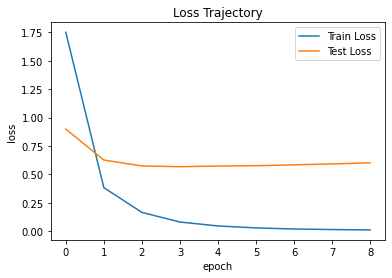

In [14]:
# plot loss
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Test Loss')
plt.legend()
plt.title("Loss Trajectory")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [15]:
# 예측
y_train_pred = model.predict_classes(X_train_tfidf, batch_size=BATCH)
y_test_pred = model.predict_classes(X_test_tfidf, batch_size=BATCH)
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Train Accuracy: 0.9992929114371575
Test Accuracy: 0.8271375464684015


## [Functional API]

- 개행문자 제거
- 불용어 제거 및 최소 단어 길이 설정
- 어간
- functional API
    - `predict_classes` 없음.
    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
훈련 데이터: 11314, 훈련 라벨: 11314
테스트 데이터: 7532, 훈련 라벨: 7532

라벨 종류:
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
   샘플 훈련 데

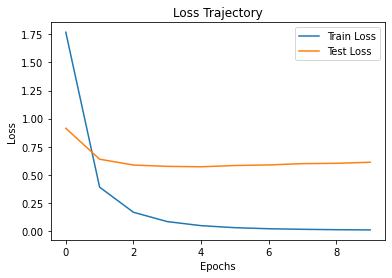

Train Accuracy: 0.9995580696482235
Test Accuracy: 0.8248805098247477


In [16]:
# module import
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from nltk import pos_tag
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 1) 데이터 로드
train_data = fetch_20newsgroups(subset='train')
test_data = fetch_20newsgroups(subset='test')

# 2) 데이터 준비
X_train, y_train = train_data.data, train_data.target
X_test, y_test = test_data.data, test_data.target
print(f"훈련 데이터: {len(X_train)}, 훈련 라벨: {len(y_train)}")
print(f"테스트 데이터: {len(X_test)}, 훈련 라벨: {len(y_test)}")

# 3) 샘플 데이터 확인
print('')
print("라벨 종류:")
print(train_data.target_names)
print(f"   샘플 훈련 데이터")
print(X_train[0])
print(f"   샘플 훈련 데이터 라벨")
print(y_train[0], train_data.target_names[y_train[0]])
print()

# 4) 전처리
def preprocessing(text):
    '''
    - 구둣점, 개행문자 제거.
    - 토큰화: 문서~문장~단어, 소문자화.
    - 불용어 제거, 최소 단어 길이 설정.
    - 어간 추출.
    - 품사 태그.
    - 표제어 추출.
    '''
    
    # 구둣점, 개행문자 제거
    temp = ""
    for t in text:
        if t in string.punctuation: # 구둣점 제거
            temp += " "
        else:
            temp += t
    temp = temp.strip('\n') # 개행문자 제거

    # 토큰화, 소문자
    tokens = []
    for sent in nltk.sent_tokenize(temp):
        for word in nltk.word_tokenize(sent):
            tokens.append(word.lower())
    
    # 불용어 제거, 최소 단어 길이 3 설정
    stopwords_list = stopwords.words('english')
    token_list = []
    for token in tokens:
        if token not in stopwords_list and len(token) >= 3:
            token_list.append(token)
    
    # 어간 추출
    stemmer = PorterStemmer()
    try:
        token_list = [stemmer.stem(word) for word in tokens]
    except:
        token_list = token_list
    
    # 품사 태그
    tagged_tokens = pos_tag(tokens)

    # 표제어 추출
    n_tags = ['NN','NNP','NNPS','NNS']
    v_tags = ['VB','VBD','VBG','VBN','VBP','VBZ']

    lemmatizer = WordNetLemmatizer()

    def prat_lemmatize(token, tag):
        if tag in n_tags:
            return lemmatizer.lemmatize(token, 'n')
        elif tag in v_tags:
            return lemmatizer.lemmatize(token, 'v')
        else:
            return lemmatizer.lemmatize(token, 'n')
    
    lemmatized_tokens = [prat_lemmatize(token, tag) for token, tag in tagged_tokens]
    
    # 최종 전처리 텍스트
    preprocessed_text = " ".join(lemmatized_tokens)

    return preprocessed_text

# 데이터 전처리
X_train_preprocessed = []
for train_text in X_train:
    X_train_preprocessed.append(preprocessing(train_text))

X_test_preprocessed = []
for test_text in X_test:
    X_test_preprocessed.append(preprocessing(test_text))

# 전처리 데이터 확인
print(f"전처리된 훈련 데이터: {len(X_train_preprocessed)}")
print(f"전처리된 테스트 데이터: {len(X_test_preprocessed)}")
print()
print(f"   전처리된 샘플 훈련 데이터")
print(X_train_preprocessed[0])
print()

# 5) TFIDF 행렬 생성
vectorizer = TfidfVectorizer(min_df=2,
                             ngram_range=(1, 2),
                             stop_words='english',
                             max_features=10000)

tfidf_vectorizer = vectorizer.fit(X_train_preprocessed)
print(f"Vectorizer:\n {tfidf_vectorizer}\n")
print(f"Vectorizer에 사용된 단어 확인:\n{tfidf_vectorizer.get_feature_names()}\n")
X_train_tfidf = tfidf_vectorizer.transform(X_train_preprocessed).todense() # 밀집행렬
X_test_tfidf = tfidf_vectorizer.transform(X_test_preprocessed).todense()
print(f"훈련 데이터 tfidf: {X_train_tfidf.shape}")
print(f"테스트 데이터 tfidf: {X_test_tfidf.shape}")
print()

# 6) 모델 파라미터
np.random.seed(42) # 시드 고정
n_classes = len(np.unique(y_train)) # 라벨 수
BATCH = int(input('배치 사이즈 설정: '))
EPOCHS = int(input('학습 에폭 수 설정: '))
n_hidden = int(input('은닉 노드 수 설정: '))

# 7) 범주형 변수 원핫인코딩
Y_train = to_categorical(y_train, n_classes)
Y_test = to_categorical(y_test, n_classes)

# 8) 모델 레이어 설정
X_input = Input(batch_shape=(None, X_train_tfidf.shape[1]))
X_hidden = Dense(n_hidden, activation='relu')(X_input)
X_hidden = Dropout(0.5)(X_hidden)
y_output = Dense(n_classes, activation='softmax')(X_hidden)

# 9) 모델 컴파일
model = Model(X_input, y_output)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001))
print("========= 모델 전체 구조 =========")
print(model.summary())
print()

# 10) 모델 학습
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
hist = model.fit(X_train_tfidf, Y_train,
                 batch_size=BATCH,
                 epochs=EPOCHS,
                 validation_data=(X_test_tfidf, Y_test),
                 callbacks=[es])

# 11) plot loss
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Test Loss')
plt.legend()
plt.title('Loss Trajectory')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# 12) 예측 및 결과 확인
y_train_pred = model.predict(X_train_tfidf)
y_train_pred = np.argmax(y_train_pred, axis=1)
y_test_pred = model.predict(X_test_tfidf)
y_test_pred = np.argmax(y_test_pred, axis=1)
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")

# =========== 테스트 ===========

In [ ]:
for sent in nltk.sent_tokenize('I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s early 70s.If anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail.'):
    print(sent)

I was wondering if anyone out there could enlighten me on this car I saw the other day.
It was a 2-door sports car, looked to be from the late 60s early 70s.If anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail.


In [ ]:
test = "I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s early 70s.If anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail."


tokens = []
for sent in nltk.sent_tokenize(test): # 문단 -> 문장
    for word in nltk.word_tokenize(sent): # 문장 -> 단어
        tokens.append(word.lower()) # 소문자
print("토큰화")
print(tokens)
print()

# 불용어 제거, 길이 3이상인 단어만 남기기
stopwords_list= stopwords.words('english')
tokens = [token for token in tokens if token not in stopwords_list] # 토큰 중 불용어 제거
tokens = [word for word in tokens if len(word) >= 3] # 길이 2이하 제거
print("불용어 제거")
print(tokens)
print()

# 어간 분석: optional
stemmer = PorterStemmer()
try:
    tokens = [stemmer.stem(word) for word in tokens]
except:
    tokens = tokens
print("어간 분석")
print()

# 품사 태깅
tagged_corpus = pos_tag(tokens)
print("품사 태깅")
print(tagged_corpus)
print()

# prat_lemmatize
n_tags = ['NN', 'NNP', 'NNPS', 'NNS']
v_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
lemmatizer = WordNetLemmatizer()
def prat_lemmatize(token, tag):
    if tag in n_tags:
        return lemmatizer.lemmatize(token, 'n')
    elif tag in v_tags:
        return lemmatizer.lemmatize(token, 'v')
    else:
        return lemmatizer.lemmatize(token, 'n')

print("prat_lemmatize")
for token, tag in tagged_corpus:
    print(prat_lemmatize(token, tag))
print()

토큰화
['i', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'i', 'saw', 'the', 'other', 'day', '.', 'it', 'was', 'a', '2-door', 'sports', 'car', ',', 'looked', 'to', 'be', 'from', 'the', 'late', '60s', 'early', '70s.if', 'anyone', 'can', 'tellme', 'a', 'model', 'name', ',', 'engine', 'specs', ',', 'years', 'of', 'production', ',', 'where', 'this', 'car', 'is', 'made', ',', 'history', ',', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', ',', 'please', 'e-mail', '.']

불용어 제거
['wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', '2-door', 'sports', 'car', 'looked', 'late', '60s', 'early', '70s.if', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'e-mail']

어간 분석

품사 태깅
[('wonder', 'NN'), ('anyon', 'NN'), ('could', 'MD'), ('enlighten', 'VB'), ('car', 'NN'), ('saw', 'JJ'), ('day', '

* stemmer 때문에 이상한 건가?
> 애초에 위에 lxr 등등 이상한 이메일 있었다.

In [ ]:
# 전처리 진행
X_train_preprocessed = []
for text in X_train:
    X_train_preprocessed.append(preprocessing(text))

X_test_preprocessed = []
for text in X_test:
    X_test_preprocessed.append(preprocessing(text))

# 전처리 후 데이터 확인
print("전처리된 훈련용 샘플 이메일")
print(X_train_preprocessed[0])

전처리된 훈련용 샘플 이메일
lerxst wam umd edu thing subject car nntp post host rac3 wam umd edu organ univers maryland colleg park line wonder anyon could enlighten car saw day door sport car look late 60 earli 70 call bricklin door realli small addit front bumper separ rest bodi know anyon tellm model name engin spec year product car make histori whatev info funki look car plea mail thank bring neighborhood lerxst


* tf-idf vectorizer 결과
> 책 코드에 왜 
```
x_train_2 = vectorizer.fit(x_train_preprocessed)
x_train_2 = vectorizer.transform(x_train_preprocessed).todense()
```
굳이 이렇게 두 개 나눠놨는지 모르겠다.

In [ ]:
test_vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                                  stop_words='english',
                                  max_features=10000)

test_matrix = test_vectorizer.fit_transform(X_train_preprocessed)
test_matrix

<11314x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 1074009 stored elements in Compressed Sparse Row format>

In [ ]:
test_vectorizer_2 = TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                                    stop_words='english',
                                    max_features=10000)
test_2 = test_vectorizer.fit(X_train_preprocessed)
test_2

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=10000,
                min_df=2, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

* 모델링 단계

In [ ]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])